## MARKET DATA ONLY 

__Notes__: This ran on a kernel. Lots of attention paid to memory. Scored almost identical to my real world model. Though it runs on the kernel, it does its own test set

In [1]:
# copy our file into the working directory (make sure it has .py suffix)
from shutil import copyfile

for file in ['sigma_imports.py', 'sigma_code.py', 'sigma_transforms.py']:
    path = "../input/scripts-sigma/"
    copyfile(src = path + file, dst = "../working/" + file)

for file in ['__init__.py', 'pandas_feature_union.py']:
    path = "../input/github-code/"
    copyfile(src = path + file, dst = "../working/" + file)
    
from sigma_imports import *
from sigma_code import *
from sigma_transforms import *
from __init__ import QuickPipeline_mod
from pandas_feature_union import PandasFeatureUnion
tqdm.pandas() 

In [2]:
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()
data, df_news = env.get_training_data()
# MARKET DATA ONLY

Loading the data... This could take a minute.
Done!


In [3]:
del df_news
gc.collect()

11

In [4]:
data.head()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
0,2007-02-01 22:00:00+00:00,A.N,Agilent Technologies Inc,2606900.0,32.19,32.17,0.005938,0.005312,NaN,NaN,-0.001860,0.000622,NaN,NaN,0.034672,1.0
1,2007-02-01 22:00:00+00:00,AAI.N,AirTran Holdings Inc,2051600.0,11.12,11.08,0.004517,-0.007168,NaN,NaN,-0.078708,-0.088066,NaN,NaN,0.027803,0.0
2,2007-02-01 22:00:00+00:00,AAP.N,Advance Auto Parts Inc,1164800.0,37.51,37.99,-0.011594,0.025648,NaN,NaN,0.014332,0.045405,NaN,NaN,0.024433,1.0
3,2007-02-01 22:00:00+00:00,AAPL.O,Apple Inc,23747329.0,84.74,86.23,-0.011548,0.016324,NaN,NaN,-0.048613,-0.037182,NaN,NaN,-0.007425,1.0
4,2007-02-01 22:00:00+00:00,ABB.N,ABB Ltd,1208600.0,18.02,18.01,0.011791,0.025043,NaN,NaN,0.012929,0.020397,NaN,NaN,-0.017994,1.0


In [5]:
data.shape

(4072956, 16)

In [6]:
# TIME FEATURE EXTRACTION
import datetime as dt

data['day_name'] = data.time.dt.day_name()
data['month_name'] = data.time.dt.month_name()
data['month'] = data.time.dt.month
data['year'] = data.time.dt.year
data['day'] = data.time.dt.dayofweek
data['quarter'] = data.time.dt.quarter

# make obj version
for feat in ['year', 'quarter']:
    colName = feat + '_obj'    
    data[colName] = data[feat].astype(str) + '_' 

In [7]:
# MACD - BETTER FORM

def macd(dframe):
    
    """
    If macd is negative/positive, the shorter term mv avg is below/above the longer 
    term and momentum is downward/upward - ish.
    
    If the signal is simply the ema of macd. If macd is less/greater than the signal,
    whether pos or neg, the momentum is bear/bullish
    
    Ex
    -----
    both signal and macd are negative. However, macd is noticably less
    negative than the signal. Interpretation: the asset has been in a short term down
    trend (short term down trend could be part of a long term down/up trend). However, 
    the momentum is bullish
    
    Metrics for indicators
    ------
    Crossover: macd is below/above signal
    
    Divergence: the price diverges by a certain threshold from macd. End of 
    current trend
    
    Dramatic Rise: macd is significantly above signal - overbought
       
    """
    
    asset_close = dframe.groupby('assetCode')['close']
    ema_26 = asset_close.transform(lambda x: x.ewm(span=26).mean())
    ema_12 = asset_close.transform(lambda x: x.ewm(span=12).mean())
    # switch adjusted back to default
    
    diff = ema_12 - ema_26
    del ema_12, ema_26, asset_close
    
    return diff


data['macd'] = macd(data)

data['signal'] = (
                data.groupby('assetCode')['macd'].
                transform(lambda x: x.ewm(span=9).
                mean() )
                )

gc.collect()

21

In [8]:
macd = data['macd'].values
sig = data['signal'].values
close = data['close'].values
diff = macd - sig
div = abs(close - macd)

data['macd_cross'] = np.where(macd > sig, 1, 0).astype('bool')
data['macd_sharp_rise'] = np.where(diff > 0.09, 1, 0).astype('bool')
data['macd_div'] = np.where(div > 75, 1, 0).astype('bool')

In [9]:
del macd, sig, close, diff, div
gc.collect()


21

In [10]:
def BB_distance(dframe):
    
    '''price moves toward upper indicate bullish. This
    returns the distance from stock price to upper or lower 
    BB. If the distance turns negative, the price is above/below. 
    See indicator lambdas.
    
    Squeeze is calculate per asset. However, comparing it to the 6 month min is a bit
    more involved. For now, leave it external. It can be integrated into the func/class
    later if it is useful. Notice the shift on the rolling min(). The present squeeze value
    should not be included in the window we are comparing it with.
    '''
    
    asset_close = dframe.groupby('assetCode')['close']
    
    sd_20 = (
            asset_close.
            transform(lambda x: x.rolling(window=20).
            std()).
            values        
            )
    
    sma_20 = (
            asset_close.
            transform(lambda x: x.rolling(window=20).
            mean()).
            values
            )
    
    # convert everything to arrays   
    U = sma_20 + (sd_20*2)    
    L = sma_20 - (sd_20*2) 
    squeeze = (U - L)/ sma_20
    del sd_20, sma_20, asset_close
    
    return (U, L, squeeze)

U, L,  squeeze = BB_distance(data)


# A SHIFT IS INCLUDED TO EXCLUDE THE CURRENT VALUE TO BE COMPARED
data['squeeze'] = squeeze
sq_min = (
        data.groupby('assetCode')['squeeze'].
        transform(lambda x: x.rolling(window=126, min_periods=126).
        min().
        shift())
        )

data['low_vol'] = np.where(squeeze <= sq_min, 1, 0).astype('bool')
# need this to drop first 126 days
data['sq_min'] = sq_min

del squeeze, U, L, sq_min
gc.collect()
data.tail()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,day_name,month_name,month,year,day,quarter,year_obj,quarter_obj,macd,signal,macd_cross,macd_sharp_rise,macd_div,squeeze,low_vol,sq_min
4072951,2016-12-30 22:00:00+00:00,ZIOP.O,ZIOPHARM Oncology Inc,1608829.0,5.35,5.37,-0.003724,0.000000,0.000536,-0.001868,-0.165367,-0.138042,-0.139597,-0.135913,0.051189,0.0,Friday,December,12,2016,4,4,2016_,4_,-0.243637,-0.118384,False,False,False,0.302751,False,0.113523
4072952,2016-12-30 22:00:00+00:00,ZLTQ.O,ZELTIQ Aesthetics Inc,347830.0,43.52,43.62,-0.000689,0.000000,-0.000515,0.000493,0.002996,0.002989,0.008213,0.003210,-0.048555,0.0,Friday,December,12,2016,4,4,2016_,4_,0.583609,0.817711,False,False,False,0.057769,True,0.058580
4072953,2016-12-30 22:00:00+00:00,ZNGA.O,Zynga Inc,7396601.0,2.57,2.58,-0.011538,0.000000,-0.006004,-0.001034,-0.091873,-0.078571,-0.077252,-0.077188,0.011703,0.0,Friday,December,12,2016,4,4,2016_,4_,-0.076525,-0.054393,False,False,False,0.224950,False,0.060581
4072954,2016-12-30 22:00:00+00:00,ZTO.N,Unknown,3146519.0,12.07,12.50,-0.029743,0.007252,-0.028460,0.006719,-0.065066,-0.042146,-0.078104,-0.043813,0.083367,1.0,Friday,December,12,2016,4,4,2016_,4_,-0.070191,-0.028552,False,False,False,NaN,False,NaN
4072955,2016-12-30 22:00:00+00:00,ZTS.N,Zoetis Inc,1701204.0,53.53,53.64,-0.001678,0.003091,0.005060,0.002885,0.023127,0.028177,0.026566,0.028719,-0.016220,1.0,Friday,December,12,2016,4,4,2016_,4_,0.902471,0.776853,True,True,False,0.108592,False,0.034381


In [11]:
def rsi(x):
    
    diff = x.diff()
    mask = diff < 0
    high = abs(diff.mask(mask)).fillna(0)
    low = abs(diff.mask(~mask)).fillna(0)
    pos_rsi = high.ewm(span=14).mean()
    neg_rsi = low.ewm(span=14).mean()
    rsi = pos_rsi / (pos_rsi + neg_rsi)
    del diff, mask, high, low, pos_rsi, neg_rsi
    
    return  rsi
    

data['rsi'] = data.groupby('assetCode')['close'].transform(lambda x: rsi(x))

data.tail()

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,day_name,month_name,month,year,day,quarter,year_obj,quarter_obj,macd,signal,macd_cross,macd_sharp_rise,macd_div,squeeze,low_vol,sq_min,rsi
4072951,2016-12-30 22:00:00+00:00,ZIOP.O,ZIOPHARM Oncology Inc,1608829.0,5.35,5.37,-0.003724,0.000000,0.000536,-0.001868,-0.165367,-0.138042,-0.139597,-0.135913,0.051189,0.0,Friday,December,12,2016,4,4,2016_,4_,-0.243637,-0.118384,False,False,False,0.302751,False,0.113523,0.211271
4072952,2016-12-30 22:00:00+00:00,ZLTQ.O,ZELTIQ Aesthetics Inc,347830.0,43.52,43.62,-0.000689,0.000000,-0.000515,0.000493,0.002996,0.002989,0.008213,0.003210,-0.048555,0.0,Friday,December,12,2016,4,4,2016_,4_,0.583609,0.817711,False,False,False,0.057769,True,0.058580,0.525793
4072953,2016-12-30 22:00:00+00:00,ZNGA.O,Zynga Inc,7396601.0,2.57,2.58,-0.011538,0.000000,-0.006004,-0.001034,-0.091873,-0.078571,-0.077252,-0.077188,0.011703,0.0,Friday,December,12,2016,4,4,2016_,4_,-0.076525,-0.054393,False,False,False,0.224950,False,0.060581,0.272631
4072954,2016-12-30 22:00:00+00:00,ZTO.N,Unknown,3146519.0,12.07,12.50,-0.029743,0.007252,-0.028460,0.006719,-0.065066,-0.042146,-0.078104,-0.043813,0.083367,1.0,Friday,December,12,2016,4,4,2016_,4_,-0.070191,-0.028552,False,False,False,NaN,False,NaN,0.247785
4072955,2016-12-30 22:00:00+00:00,ZTS.N,Zoetis Inc,1701204.0,53.53,53.64,-0.001678,0.003091,0.005060,0.002885,0.023127,0.028177,0.026566,0.028719,-0.016220,1.0,Friday,December,12,2016,4,4,2016_,4_,0.902471,0.776853,True,True,False,0.108592,False,0.034381,0.694243


In [12]:
# SQ_MIN SHOULD HAVE THE MOST
data[[col for col in data.columns if data[col].isnull().sum() > 0]].isnull().sum()

returnsClosePrevMktres1      15980
returnsOpenPrevMktres1       15988
returnsClosePrevMktres10     93010
returnsOpenPrevMktres10      93054
squeeze                      69718
sq_min                      482414
rsi                           3985
dtype: int64

In [13]:
# Need to drop the first 6 months
data.dropna(inplace=True)
data.drop(['sq_min'], axis=1, inplace=True)
df = data.copy()

In [14]:
del data
gc.collect()

7

In [15]:
# JUST GRABBING THE BOOL TITLES - THERE IS AN ISSUE WITH QUICKPIPE
bool_feats = (
            TypeSelector(np.bool_).
            fit_transform(df).
            columns.
            tolist()
            )


In [16]:
from sklearn.pipeline import make_pipeline


transformer_list = [ ('numeric', make_pipeline(TypeSelector(np.number),
                                QuickPipeline_mod()
                                )
                    ),('binned_features', make_pipeline(
                        TypeSelector(np.number),
                        SelectFeatures(feat_list=['volume']),
                        KBins(n_bins=5),
                        QuickPipeline_mod()
                         )
                ), ('boolean_features', make_pipeline(
                         TypeSelector(np.bool_),
                        QuickPipeline_mod(categorical_features=bool_feats)
                        )
                   ),('categorical_features', make_pipeline(
                         TypeSelector(np.object),
                        QuickPipeline_mod() )
                        )                                           
                   ]

In [17]:
preprocess_pipeline = make_pipeline(PandasFeatureUnion(transformer_list))


In [18]:

df['date'] = df.time.dt.strftime("%Y%m%d").astype(int)
df.reset_index(drop=True, inplace=True)
# Needed for dataframe splits
dates = df['date'].unique()

# Convert targets to binary
target = ['returnsOpenNextMktres10']
label = ['label']
# df[target[0]] = (df[target[0]] > 0).astype(int)
df[label[0]] = (df[target[0]] > 0).astype(int)
# Consider vectorize - later

In [19]:
def train_feats(dframe, drops=list):
    # could do list comp
    train_feat = []
    for col in dframe.columns:
        if col not in drops:
            train_feat.append(col)
    return train_feat

feats = train_feats(df, drops=['date', 'assetCode', 'assetName', 'universe', 
                               'returnsOpenNextMktres10', 
                               'label', 'time'])


In [20]:
import warnings
warnings.filterwarnings(action='ignore')
X = preprocess_pipeline.fit_transform(df[feats])

In [21]:
df_ = pd.concat([df[[col for col in df.columns if col not in feats]] ,
                  X],
                  axis=1)

# Rerun train features for processed data
feats = train_feats(df_, drops=['date', 'assetCode', 'assetName', 'universe', 
                               'returnsOpenNextMktres10', 
                               'label', 'time'])
del X, df
gc.collect()

352

In [ ]:
df_.head()

In [22]:
import lightgbm as lgb

train_range = range(len(dates))[:int(0.70*len(dates))]
val_range = range(len(dates))[int(0.70*len(dates)):int(0.9*len(dates))]
test_range = range(len(dates))[int(0.9*len(dates)):]

In [23]:
df_[[col for col in df_.columns if df_[col].isnull().sum() > 0]].isnull().sum()

Series([], dtype: float64)

In [24]:
# KINDA LOOKS CRAPPY. THIS JUST SETS THE TRAINING/VAL SETS WITH PREDICTORS
# train data - numpys
X_train = df_[feats].loc[df_['date'].isin(dates[train_range])].values
y_train = df_[label].loc[df_['date'].isin(dates[train_range])].values

# GETS INTERESTING -> INPUTS DATA INTO INSTANCE
print(X_train.shape, y_train.shape)
lgb_train = lgb.Dataset(X_train, y_train[:,0], feature_name=feats)
del X_train, y_train
gc.collect()

(2432939, 59) (2432939, 1)


7

In [25]:
# validation data - numpys
X_v = df_[feats].loc[df_['date'].isin(dates[val_range])].values
y_v = df_[label].loc[df_['date'].isin(dates[val_range])].values

print(X_v.shape, y_v.shape)
lgb_val = lgb.Dataset(X_v, y_v[:,0], feature_name=feats),
del X_v, y_v
gc.collect()

(717963, 59) (717963, 1)


0

In [26]:
# test data
X_test = df_[feats].loc[df_['date'].isin(dates[test_range])].values
y_test = df_[label].loc[df_['date'].isin(dates[test_range])].values

print(X_test.shape, y_test.shape)

(400799, 59) (400799, 1)


In [27]:
param = {"objective" : "binary",
          "metric" : "binary_logloss",
          "verbosity" : -1,
        'random_state': 81}

# TONS OF HYPERPARAMENTERS. THIS FIT FUNC USES THE VAL SET TO TRAIN AND 
# SELECT THE BEST ITERATION

model = lgb.train(param, lgb_train, valid_sets=lgb_val, 
                  early_stopping_rounds=10) 
                  

[1]	valid_0's binary_logloss: 0.693608
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.692388
[3]	valid_0's binary_logloss: 0.691326
[4]	valid_0's binary_logloss: 0.690445
[5]	valid_0's binary_logloss: 0.689789
[6]	valid_0's binary_logloss: 0.689265
[7]	valid_0's binary_logloss: 0.688757
[8]	valid_0's binary_logloss: 0.688399
[9]	valid_0's binary_logloss: 0.688117
[10]	valid_0's binary_logloss: 0.687835
[11]	valid_0's binary_logloss: 0.687511
[12]	valid_0's binary_logloss: 0.687286
[13]	valid_0's binary_logloss: 0.68738
[14]	valid_0's binary_logloss: 0.687287
[15]	valid_0's binary_logloss: 0.687177
[16]	valid_0's binary_logloss: 0.687094
[17]	valid_0's binary_logloss: 0.687044
[18]	valid_0's binary_logloss: 0.68701
[19]	valid_0's binary_logloss: 0.686833
[20]	valid_0's binary_logloss: 0.68688
[21]	valid_0's binary_logloss: 0.686874
[22]	valid_0's binary_logloss: 0.68686
[23]	valid_0's binary_logloss: 0.686837
[24]	valid_0's binary_logloss: 

In [28]:
# FULL TEST SET DATASET VERSION
preds = model.predict(X_test, num_iteration=model.best_iteration) 
date_vec = df_['date'].loc[df_['date'].isin(dates[test_range])]
u = df_['universe'].loc[df_['date'].isin(dates[test_range])]
actual = df_[target].loc[df_['date'].isin(dates[test_range])].values[:, 0]

def custom_metric(date, pred_proba, num_target, universe):
    y = pred_proba*2 - 1
    r = num_target#.clip(-1,1) # get rid of outliers
    x = y * r * universe
    result = pd.DataFrame({'day' : date, 'x' : x})
    x_t = result.groupby('day').sum().values
    return np.mean(x_t) / np.std(x_t)


custom_metric(date_vec, preds, actual, u)

# 0.42009

0.5150650474352767

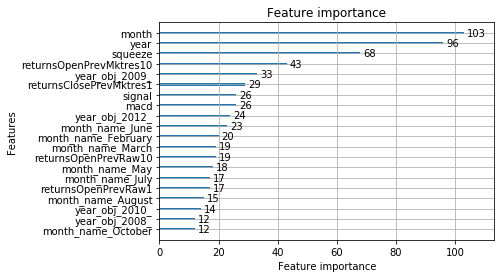

In [30]:

lgb.plot_importance(model, max_num_features=20)

In [31]:
importances = model.feature_importance()
indices = np.argsort(importances)
top = indices[::-1][:20]
for i in range(len(top)):
#     print(top[i])
    name = df_[feats].columns[top[i]]
    w = importances[top[i]] / sum(importances)
#     print(name)
    print('{} Feature: {}, weight: {}'.format(i+1, name, round(w, 3)))

1 Feature: month, weight: 0.143
2 Feature: year, weight: 0.133
3 Feature: squeeze, weight: 0.094
4 Feature: returnsOpenPrevMktres10, weight: 0.06
5 Feature: year_obj_2009_, weight: 0.046
6 Feature: returnsClosePrevMktres1, weight: 0.04
7 Feature: signal, weight: 0.036
8 Feature: macd, weight: 0.036
9 Feature: year_obj_2012_, weight: 0.033
10 Feature: month_name_June, weight: 0.032
11 Feature: month_name_February, weight: 0.028
12 Feature: returnsOpenPrevRaw10, weight: 0.026
13 Feature: month_name_March, weight: 0.026
14 Feature: month_name_May, weight: 0.025
15 Feature: returnsOpenPrevRaw1, weight: 0.024
16 Feature: month_name_July, weight: 0.024
17 Feature: month_name_August, weight: 0.021
18 Feature: year_obj_2010_, weight: 0.019
19 Feature: year_obj_2008_, weight: 0.017
20 Feature: month_name_October, weight: 0.017
